OSAR Context Generator PoW test

**Author:** [Konstantin Ustyuzhanin](https://www.facebook.com/konstantin.ustuzhanin/)<br>
**Date created:** 2021/01/27<br>
**Last modified:** 2021/02/10<br>
**Description:** Implement Objective Stimuli Active Repeater (OSAR) Context Generator.

# Installations and imports

In [67]:
# !pip install -q gym
# Install additional packages for visualization
if sys.platform != 'win32':
    !sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install pyvirtualdisplay #> /dev/null 2>&1
# !pip install -q imageio == 2.4.0
# !pip install PILLOW
# !pip install pyglet
# !pip install -q git+https://github.com/tensorflow/docs > /dev/null 2>&1
# !pip install https://github.com/ustyuzhaninky/OSAR-keras
# !pip install ../../OSAR-keras/.

fatal: destination path 'docs' already exists and is not an empty directory.


Processing d:\jorgen\projects\python\phdsub\towerproject\osar-keras\colab\docs
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01c06dd3453d46dc1c7c19f4ec2dbf47c78b36018_-py3-none-any.whl size=130019 sha256=a22c0ad097fbdf6b838f0afaae9a31120fe0ad73a0c5d2d3384358f6cc12c2e5
  Stored in directory: C:\Users\Jorgen\AppData\Local\Temp\pip-ephem-wheel-cache-iufra4uw\wheels\e2\49\65\ad176043f118d3c2d39f42e0ae696c6942482ba1c73a2d03f5
Successfully built tensorflow-docs


In [2]:
import os
import collections
import gym
import numpy as np
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple
import numpy as np

from tensorflow.keras import layers
os.environ['TF_KERAS'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
# Configuration parameters for the whole setup
seed = 42

TensorFlow version: 2.3.0
Eager execution: True


# Environment

In [3]:
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

# Agent generator

In [4]:
from OSAR import ContextGenerator

In [5]:
def get_baseline(num_hidden=10, num_inputs=env.observation_space.high.shape[0],
                 num_actions=env.action_space.n):
    
    class ActorCritic(tf.keras.Model):
        """Combined actor-critic network."""

        def __init__(
                self, 
                num_actions: int, 
                num_hidden_units: int):
            """Initialize."""
            super().__init__()

            self.common = layers.Dense(num_hidden_units, activation="relu")
            self.actor = layers.Dense(num_actions)
            self.critic = layers.Dense(1)

        def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
            x = self.common(inputs)
            return self.actor(x), self.critic(x), x

    agent = ActorCritic(num_actions, num_hidden)
    agent.compile(loss=tf.keras.losses.Huber, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=False)
    return agent

def get_OSAR(num_hidden=10, num_inputs=env.observation_space.high.shape[0],
             num_actions=env.action_space.n,
             batch_size=1,
             memory_dpi=10,
             n_turns=3):
#     state_input = layers.Input(batch_input_shape=(batch_size, num_inputs,), dtype=tf.float32, name='state_input')
#     reward_input = layers.Input(batch_input_shape=(batch_size, 1,), dtype=tf.float32, name='reward_input')
#     action_input = layers.Input(batch_input_shape=(batch_size, num_hidden,), dtype=tf.float32, name='action_input')
#     states = tf.expand_dims(state_input, axis=1)
#     rewards = tf.expand_dims(reward_input, axis=1)
#     actions = tf.expand_dims(action_input, axis=1)
#     generator = ContextGenerator(10,
#                      1,
#                      10,
#                      3,
#                      )([states, rewards, actions])

#     flt = layers.Flatten()(generator)
#     action = tf.keras.layers.Dense(num_actions, activation='softmax')(flt)#(final_state)
#     critic = tf.keras.layers.Dense(1)(flt)#(final_state)
#     agent = tf.keras.models.Model(inputs=[state_input, reward_input, action_input],
#                                   outputs=[generator[:, -1, -num_hidden:], action, critic])
#     agent.compile(loss=tf.keras.losses.Huber, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=False)
#     agent.summary()
    
    class ActorCritic(tf.keras.Model):
        """Combined actor-critic network."""

        def __init__(
                self, 
                num_actions: int, 
                num_hidden_units: int,
                memory_len: int,
                n_turns: int):
            """Initialize."""
            super().__init__()

#             self.common = layers.Dense(num_hidden_units, activation="relu")
            self.generator = ContextGenerator(num_hidden_units,
                     batch_size,
                     memory_len,
                     n_turns,
                     kernel_regularizer='l2',
                     bias_regularizer='l2',
                     )
            self.gru = tf.keras.layers.GRU(num_hidden_units,
                     kernel_regularizer='l2',
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     bias_regularizer='l2',
                     )
            self.actor = layers.Dense(num_actions)
            self.critic = layers.Dense(1)

        def call(self, inputs: List[tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
            state = inputs[0]
            reward = tf.cast(inputs[1], tf.float32)
            action = inputs[2]
#             state = self.common(state)
            state = tf.expand_dims(state, axis=1)
            reward = tf.expand_dims(reward, axis=1)
            action = tf.expand_dims(action, axis=1)
            generator = self.generator([state, reward, action])
            tiled_state = tf.tile(state, (1, generator.shape[1], 1))
            x = self.gru(tf.concat([generator, tiled_state], axis=-1))
            
            return self.actor(x), self.critic(x), x#[:, -1, -num_hidden:]
    agent = ActorCritic(num_actions, num_hidden, memory_dpi, n_turns)
    agent.compile(loss=tf.keras.losses.Huber, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=False)
    return agent

# Functions

In [6]:
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns state, reward and done flag given an action."""

    state, reward, done, _ = env.step(action)
    return (state.astype(np.float32), 
            np.array(reward, np.int32), 
            np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
    return tf.numpy_function(env_step, [action], 
                             [tf.float32, tf.int32, tf.int32])

In [18]:
def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int,
    m_type: int=1,
    initial_reward: tf.Tensor = tf.zeros((1, 1), dtype=tf.int32), 
    initial_action: tf.Tensor = None,
) -> List[tf.Tensor]:
    """Runs a single episode to collect training data."""

    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    x_values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    initial_state_shape = initial_state.shape
    state = initial_state
    last_action = initial_action
    reward = initial_reward
        
    for t in tf.range(max_steps):
        tf.autograph.experimental.set_loop_options(
            shape_invariants=[(reward, tf.TensorShape([1, 1]))]
            )
        
        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)
        
        # Run the model and to get action probabilities and critic value
        if m_type == 1:
            action_logits_t, value, last_action = model(state)
        else:
            action_logits_t, value, last_action = model([state, reward, tf.nn.softmax(last_action)])
        
        # store last_action values
        x_values = x_values.write(t, last_action)
        
        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, env.action_space.n)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)
        
        # Store critic values
        values = values.write(t, tf.squeeze(value))

        # Store log probability of the action chosen
        action_probs = action_probs.write(t, action_probs_t[0, action])

        # Apply action to the environment to get next state and reward
        state, episode_reward, done = tf_env_step(action)
        state.set_shape(initial_state_shape)

        # Store reward
        rewards = rewards.write(t, episode_reward)
        reward = tf.expand_dims(tf.reshape(episode_reward, (1,)), 0)

        if tf.cast(done, tf.bool):
            break

    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    x_values = x_values.stack()

    return action_probs, values, rewards, x_values

In [ ]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
    """Compute expected returns per timestep."""

    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / 
                   (tf.math.reduce_std(returns) + eps))

    return returns

In [ ]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
    """Computes the combined actor-critic loss."""

    advantage = returns - values

    action_log_probs = tf.math.log(action_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

    critic_loss = huber_loss(values, returns)

    return actor_loss + critic_loss

In [116]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int,
    initial_action=tf.zeros((1, 10,), dtype=tf.float32),
    m_type:int=1) -> Tuple[tf.Tensor, List[tf.Tensor]]:
    """Runs a model training step."""

    with tf.GradientTape() as tape:

        # Run the model for one episode to collect training data
        action_probs, values, rewards, x_values = run_episode(
            initial_state, model, max_steps_per_episode, m_type=m_type, initial_action=initial_action) 

        # Calculate expected returns
        returns = get_expected_return(rewards, gamma)

        # Convert training data to appropriate TF tensor shapes
        action_probs, values, returns = [
            tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

        # Calculating loss values to update our network
        loss = compute_loss(action_probs, values, returns)

        # Compute the gradients from the loss
        grads = tape.gradient(loss, model.trainable_variables)

        # Apply the gradients to the model's parameters
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    episode_reward = tf.math.reduce_sum(rewards)
    episode_x = tf.math.reduce_mean(x_values)
    episode_loss = tf.math.reduce_mean(loss)
    episode_actions = tf.math.reduce_mean(action_probs)
    episode_values = tf.math.reduce_sum(values)

    return episode_reward, [episode_reward, episode_x, episode_loss, episode_actions, episode_values]

In [20]:
def run(model:tf.keras.Model,
        inits:int,
        max_episodes:int,
        max_steps_per_episode:int,
        reward_threshold:float,
        gamma:int,
        m_type:int=1) -> List[tf.Tensor]:
    
    running_reward = 0
    train_history = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    
    with tqdm.trange(max_episodes) as t:
        for i in t:
            initial_state = tf.constant(env.reset(), dtype=tf.float32)
            episode_reward, hist = train_step(
                initial_state, model, optimizer, gamma,
                max_steps_per_episode, m_type=m_type,
                initial_action=tf.zeros((1, 10,), dtype=tf.float32))
            episode_reward = tf.cast(episode_reward, tf.float32)
            hist = tf.concat([
                tf.cast(tf.expand_dims(x, 0), tf.float32) for x in hist], axis=0)
            train_history = train_history.write(i, hist)
            
            running_reward = episode_reward*0.01 + running_reward*.99

            t.set_description(f'Episode {i}')
            t.set_postfix(
                episode_reward=episode_reward.numpy(), running_reward=running_reward.numpy())

            # Show average episode reward every 10 episodes
            if i % 10 == 0:
                pass#print(f'Episode {i}: average reward: {avg_reward}')

            if running_reward > reward_threshold:  
                break
    
    train_history = train_history.stack()
    print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')
    return train_history

# Training

In [80]:
max_episodes = 10000
max_steps_per_episode = 1000
num_hidden = 10
# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195.0

# Discount factor for future rewards
gamma = 0.99

In [22]:
%%time
baseline = get_baseline()
baseline_hist = run(baseline, num_hidden, max_episodes, max_steps_per_episode, reward_threshold, gamma, m_type=1)

Episode 1386:  14%|███▏                   | 1386/10000 [01:41<10:33, 13.61it/s, episode_reward=200, running_reward=195]


Solved at episode 1386: average reward: 195.01!
Wall time: 1min 41s


In [14]:
%%time
osar = get_OSAR(num_hidden=num_hidden,)
osar_hist = run(osar, num_hidden, max_episodes, max_steps_per_episode, reward_threshold, gamma, m_type=2)

Episode 1299:  13%|██▋                  | 1299/10000 [26:32<2:57:50,  1.23s/it, episode_reward=200, running_reward=195]


Solved at episode 1299: average reward: 195.03!
Wall time: 26min 33s


# Results

In [15]:
labels = ['episode_reward', 'episode_x', 'episode_loss', 'episode_actions', 'episode_values']

In [23]:
def get_running_reward(rewards):
    running_reward = [0]
    for r in rewards:
        running_reward.append(r*0.01 + running_reward[-1]*.99)
    return running_reward

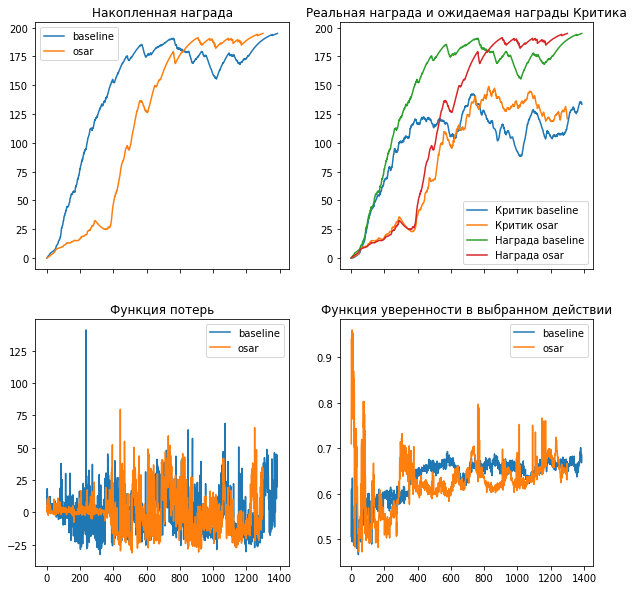

In [29]:

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 10))

ax[0, 0].plot(get_running_reward(baseline_hist[:, 0]), label='baseline')
ax[0, 0].plot(get_running_reward(osar_hist[:, 0]), label='osar')
ax[0, 0].set_title('Накопленная награда')
ax[0, 0].legend()
ax[1, 0].plot(baseline_hist[:, 2], label='baseline')
ax[1, 0].plot(osar_hist[:, 2], label='osar')
ax[1, 0].set_title('Функция потерь')
ax[1, 0].legend()
ax[0, 1].plot(get_running_reward(baseline_hist[:, 4]), label='Критик baseline')
ax[0, 1].plot(get_running_reward(osar_hist[:, 4]), label='Критик osar')
ax[0, 1].plot(get_running_reward(baseline_hist[:, 0]), label='Награда baseline')
ax[0, 1].plot(get_running_reward(osar_hist[:, 0]), label='Награда osar')
ax[0, 1].set_title('Реальная награда и ожидаемая награды Критика')
ax[0, 1].legend()
ax[1, 1].plot(baseline_hist[:, 3], label='baseline')
ax[1, 1].plot(osar_hist[:, 3], label='osar')
ax[1, 1].set_title('Функция уверенности в выбранном действии')
ax[1, 1].legend()
plt.show()

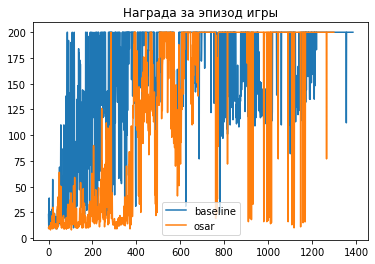

In [28]:
plt.plot(baseline_hist[:, 0], label='baseline')
plt.plot(osar_hist[:, 0], label='osar')
plt.title('Награда за эпизод игры')
plt.legend()
plt.show()

# Visualisation

In [105]:
# Render an episode and save as a GIF file

import sys
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display
import tensorflow_docs.vis.embed as embed

if sys.platform != 'win32':
    display = Display(visible=0, size=(400, 300))
    display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int, m_type:int=1, inits:int=num_hidden,): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
    
    reward, loop_var = tf.zeros((1, 1), tf.float32), tf.zeros((1, inits), tf.float32)

    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        
        if m_type == 1: 
            action_probs, _, loop_var = model(state)
            action = np.argmax(np.squeeze(tf.nn.softmax(action_probs)))
        else:
            action_probs, _, loop_var = model([state, reward, tf.nn.softmax(loop_var)])
            action = np.argmax(np.squeeze(tf.nn.softmax(action_probs)))
        
        state, reward, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        reward = tf.expand_dims(tf.constant(reward, dtype=tf.float32), axis=0)
        reward = tf.expand_dims(reward, 0)

        # Render screen every 10 steps
        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))

        if done:
            break
    env.close()
    return images

## Untrained:

### Baseline

Episode 99: 100%|████████████████████████████| 100/100 [00:03<00:00, 25.12it/s, episode_reward=50, running_reward=34.2]



Solved at episode 99: average reward: 34.15!



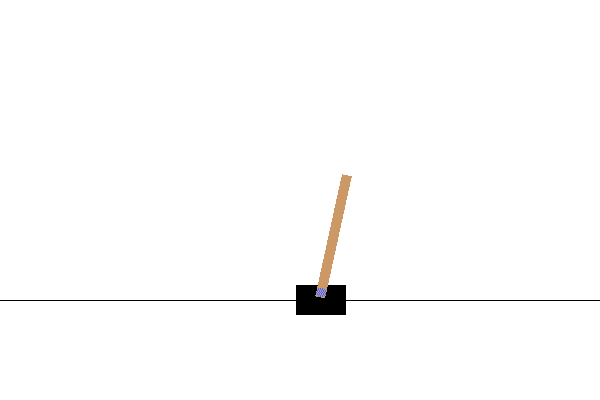

In [112]:
# Save GIF image
buggy_baseline = get_baseline()
run(buggy_baseline, 10, 100, max_steps_per_episode, reward_threshold, gamma, m_type=1)
images = render_episode(env, buggy_baseline, max_steps_per_episode)
image_untrained_baseline_file = '../images/cartpole-baseline-untrained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_untrained_baseline_file, save_all=True, append_images=images[1:], loop=0, duration=1)
embed.embed_file(image_untrained_baseline_file)

### OSAR (Context Genrator + GRU Only)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py", line 4354, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "C:\Anaconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)


Episode 99: 100%|████████████████████████████| 100/100 [00:27<00:00,  3.60it/s, episode_reward=15, running_reward=11.3]



Solved at episode 99: average reward: 11.29!



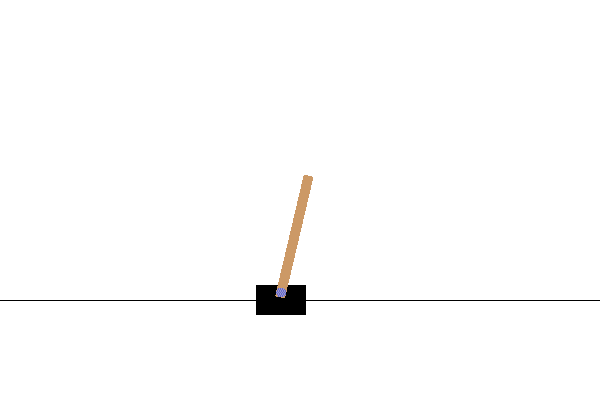

In [117]:
# Save GIF image
buggy_osar = get_OSAR(num_hidden=10,)
run(buggy_osar, 10, 100, max_steps_per_episode, reward_threshold, gamma, m_type=2)
images = render_episode(env, buggy_osar, max_steps_per_episode, m_type=2)
image_untrained_osar_file = '../images/cartpole-osar-untrained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_untrained_osar_file, save_all=True, append_images=images[1:], loop=0, duration=1)
embed.embed_file(image_untrained_osar_file)

## Trained:

### Baseline


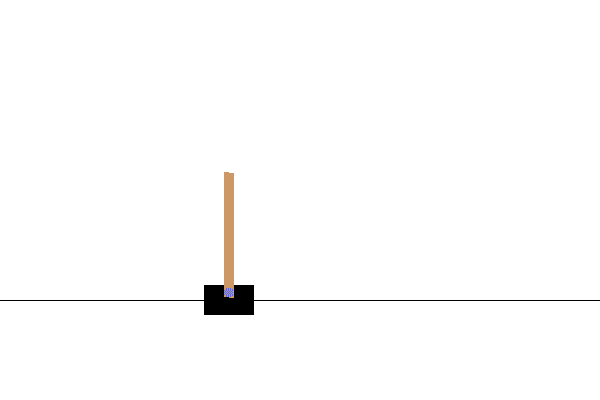

In [107]:
# Save GIF image
images = render_episode(env, baseline, max_steps_per_episode)
image_trained_baseline_file = '../images/cartpole-baseline-trained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_trained_baseline_file, save_all=True, append_images=images[1:], loop=0, duration=1)
embed.embed_file(image_trained_baseline_file)

### OSAR (Context Genrator + GRU Only)


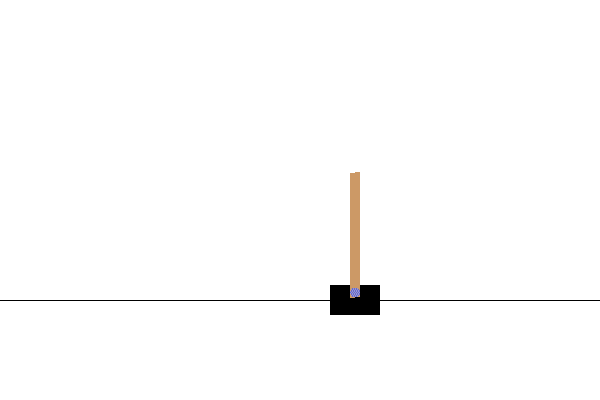

In [108]:
# Save GIF image
images = render_episode(env, osar, max_steps_per_episode, m_type=2)
image_trained_osar_file = '../images/cartpole-osar-trained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_trained_osar_file, save_all=True, append_images=images[1:], loop=0, duration=1)
embed.embed_file(image_trained_osar_file)